<a href="https://colab.research.google.com/github/DamianDominoDavis/sommalier/blob/master/sommalier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#V.1 Exploring the green reds
<p>
    <ol type="a">
        <li>Write a function that will plot a scatterplot matrix of your red wine data. Your function should plot wines with quality over some “good_threshold” as one color, and wines below some “bad_threshold” as another. Your plotting function should have the option to save a .png of your plots. Here’s an example function definition: <pre>def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False)</pre></li>
    </ol>
</p>


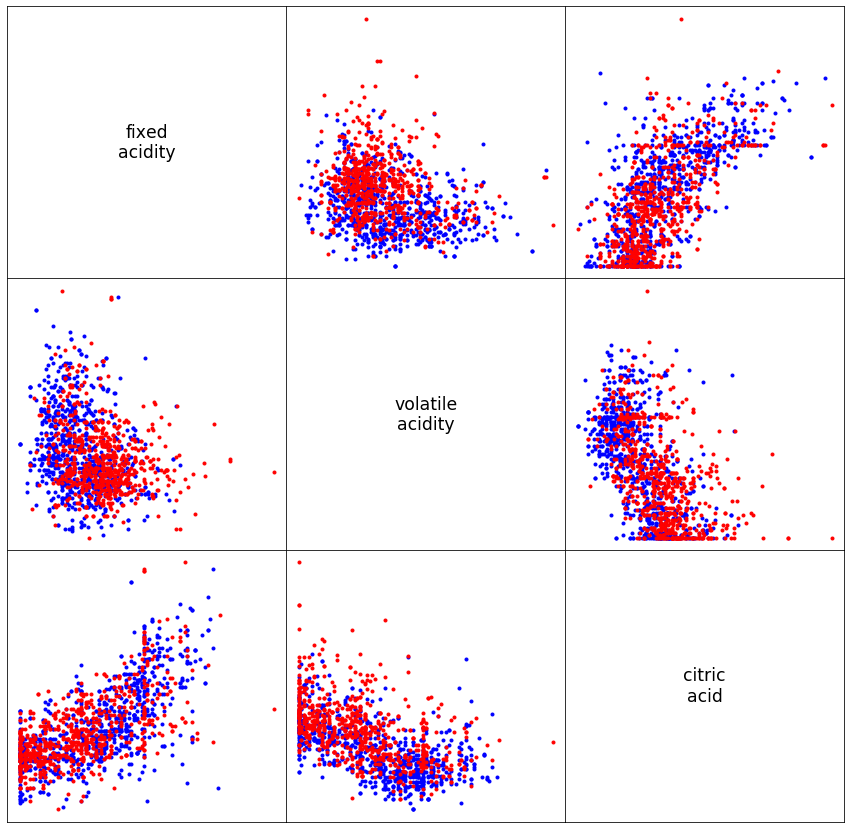

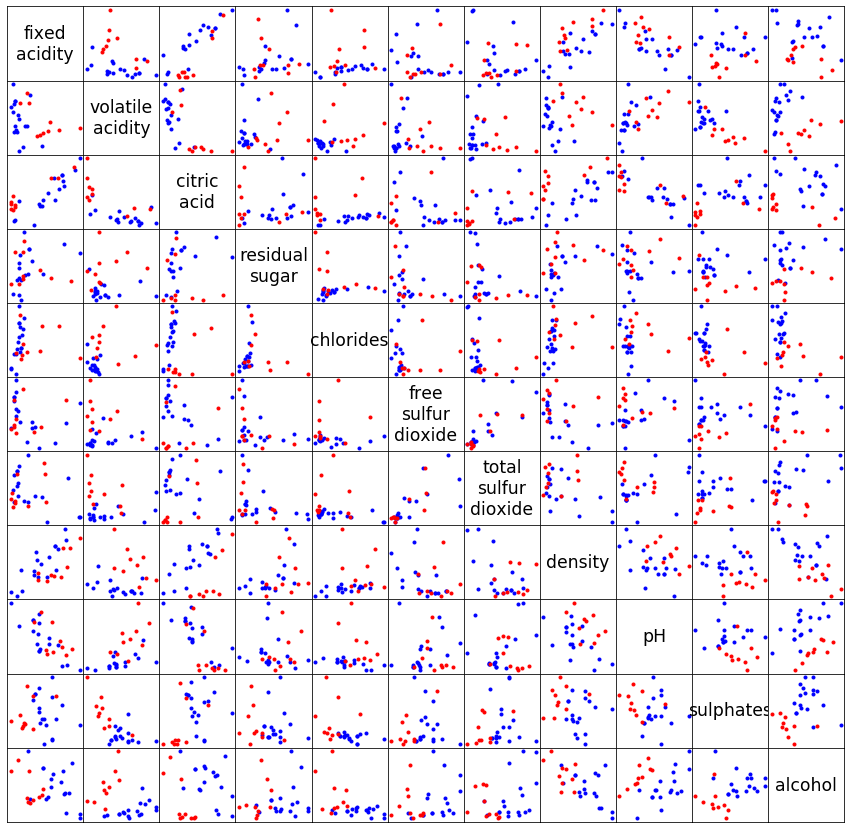

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas

def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save=False):
    wine_good = wine_data[wine_data.quality >= good_threshold]
    wine_bad = wine_data[wine_data.quality <= bad_threshold]
    dimens = tuple([x for x in wine_data if x != 'quality'])
    dlen = len(dimens)
    style_good, style_bad = ('b.', 'r.')
    txt_args = {'size': 'xx-large',
                'horizontalalignment': 'center',
                'verticalalignment': 'center'}
    fig = plt.figure(figsize=[15, 15])
    fig.subplots_adjust(wspace=0, hspace=0)
    ax = fig.subplots(dlen, dlen)
    for row in range(0, dlen):
        for col in range(0,dlen):
            ax[row,col].get_xaxis().set_visible(False)
            ax[row,col].get_yaxis().set_visible(False)
            if row == col:
                ax[row,col].text(0.5, 0.5, dimens[row].replace(' ', '\n'), txt_args)
            else:
                ax[row,col].plot(dimens[row], dimens[col], style_good, data=wine_good)
                ax[row,col].plot(dimens[row], dimens[col], style_bad, data=wine_bad)
    if save:
        return fig.savefig('wine_plot.png', dpi=100)


url = 'https://raw.githubusercontent.com/DamianDominoDavis/sommalier/master/winequality-red.csv'
csv = pandas.read_csv(url, sep=';')
small = csv[['fixed acidity', 'volatile acidity', 'citric acid', 'quality']]
plot_scatter_matrix(small, 6, 5, save=True)
plot_scatter_matrix(csv, 8, 3)


<p>
    <ol type="a" start=2>
        <li>Now that you’ve had a chance to analyze different chemical factors in red wines and their relationship with high scores (8 or higher) and low scores (3 or lower), which factors do you think will be most useful to your perceptron for distinguishing high quality vs. low quality wines? Why?

---
Correlation doesn't matter directly so much as distinctly different mappings for good vs bad wine properties on any two given axes; visually, that good and bad need not be in a pattern, or even all together, but that a clear "good side" and "bad side" exist, without any overlap at all. Which, if any, of these axes will be separable depends as much on the threshold selections as the input data.</li>
    </ol>
</p>


<h1 color="red">V.2 Learning to perceptron</h1>
<p>
    <ol type="a">
        <li><strong>Implement a perceptron</strong> that:
            <ul><small>
                <li>Has randomly initialized weights and bias</li>
                <li>Uses the Rosenblatt perceptron learning rule (with changeable learning rate)</li>
                <li>Utilizes the heaviside step activation function (discrete version)</li>
            </small></ul>
        </li>
        <li>You’ll need to implement a function to <strong>train your perceptron</strong>. Your training function
should take in your red wine data as a parameter and should:
            <ul><small>
                <li>Have a way to specify number of training epochs</li>
                <li>Train your perceptron until it makes no errors, if training epochs is set to 0,</li>
                <li>Have a way to specify learning rate.</li>
                <li>Return a list of python tuples containing (performance):<br/><pre>[(current_epoch, num_errors_at_epoch_end, [array_of_weights], bias), &hellip; ]</pre></li>
            </small></ul>
        </li>
        <li>Now that you have a perceptron, a way to train your perceptron, and some data, you need a way to confirm that your perceptron actually works. Write a function that will take the output of your perceptron training function and your red wine data and generate two plots in one figure:
            <ul><small>
                <li>The first plot should <strong>plot the number of errors your perceptron made as a function of epoch</strong>. Be careful with how you calculate errors!</li>
                <li>The second plot should <strong>plot the decision boundary</strong> of your perceptron and also show ‘good’ and ‘bad’ wine data points on the final training epoch. This second plot should also shade ‘good’ and ‘bad’ areas!</li>
                <li>Your function should allow the user to specify a <strong>specific epoch</strong> and see what the decision boundary of the perceptron was on that epoch. If a negative epoch is given, cause the plots to show the last epoch.</li>
            </small></ul>
        </li>
        <li>Your perceptron appears to work... but why is it taking so many epochs to train? Maybe you can modify the red wine data to help the perceptron learn more quickly? Use the function you just created in part c) to plot and verify that your perceptron is learning more efficiently! <em><br/>(Data standardization.)</em>
        </li>
    </ol>
</p>


success in 4 epochs
success in 13240 epochs


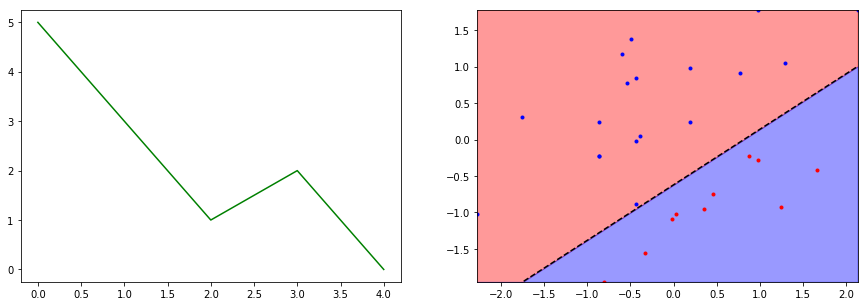

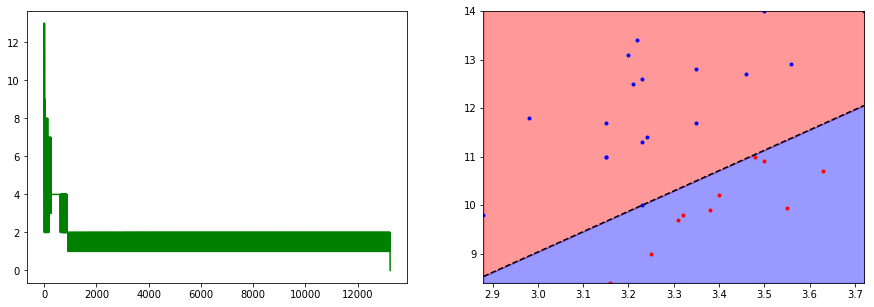

In [62]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas

class Perceptron:
    def __init__(self, data, stand=True):
        tmp = data[[x for x in data if x != 'quality']]
        if stand:
            tmp = (tmp-tmp.mean()) / tmp.std()
        tmp['quality'] = data['quality']
        self.data = tmp
        self.dimens = tuple(x for x in self.data if x != 'quality')
        self.D = len(self.dimens)

    def train(self, threshold, rate, epoch=0):
        ret = []
        bias = random.uniform(-1,1)
        weights = [random.uniform(-1,1)] * self.D
        self.data['expected'] = self.data['quality'] >= threshold
        cur_epoch = 0
        while cur_epoch < epoch or epoch == 0:
            num_errors = 0
            for i in range(self.data.shape[0]):
                xi = self.data.iloc[i]
                cmp = bias + sum([weights[d] * xi[self.dimens[d]] for d in range(self.D)])
                yi = int(cmp > 0)
                error = int(xi.expected) - yi
                if error:
                    num_errors += 1
                    weights = [weights[w] + error * rate * xi[self.dimens[w]] for w in range(self.D)]
                    bias += error * rate
            ret.append(tuple([cur_epoch, num_errors, weights, bias]))
            cur_epoch += 1
            if num_errors == 0:
                break
        return ret

def report(performance, data, good_thresh, bad_thresh,  epoch=-1, save_plot=False):
    fig = plt.figure(figsize=[15, 5])
    ax, bx = fig.subplots(1, 2)
    print('{} in {} epochs'.format('success' if performance[-1][1] == 0 else 'failed', performance[-1][0]))
    story = pandas.DataFrame(performance, columns=['epoch', 'errors', 'weights', 'bias'])
    ax.plot(story['epoch'], story['errors'], 'g-')

    tgood = data[data['quality'] >= gthresh]
    tbad = data[data['quality'] <= bthresh]
    bx.axis([np.min(data.pH), np.max(data.pH), np.min(data.alcohol), np.max(data.alcohol)])
    bx.plot(tgood['pH'], tgood['alcohol'], 'b.')
    bx.plot(tbad['pH'], tbad['alcohol'], 'r.')

    e = performance[epoch if 0 < epoch and epoch < len(performance) else -1]
    a, c = -(e[3]/e[2][1])/(e[3]/e[2][0]), -(e[3]/e[2][1])
    x = [np.min(data.pH), np.max(data.pH)]
    y = [a*xi + c for xi in x]
    ym = [np.min(data.alcohol), np.max(data.alcohol)]
    bx.plot(x, [a*x[0]+c, a*x[1]+c], "k--")
    bx.fill_between(x, y, ym[1], where=y<=ym[1], color="red", alpha=.4)
    bx.fill_between(x, y, ym[0], where=y<=ym[1]+100, color="blue", alpha=.4)



url = 'https://raw.githubusercontent.com/DamianDominoDavis/sommalier/master/winequality-red.csv'
gthresh, bthresh = 8, 3
training = pandas.read_csv(url, sep=';')
training = training[['pH', 'alcohol','quality']]
training = training[(training.quality >= gthresh) | (training.quality <= bthresh)]
per = Perceptron(training)
report(per.train(gthresh, 1), per.data, gthresh, bthresh)

poor = Perceptron(training, stand=False)
report(poor.train(gthresh, 1, epoch=15000), poor.data, gthresh, bthresh)
